# T5 Time Series Forecasting in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import os
import random
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    'lags': 168, # 7 * 24 = 168 (1 week past)
    'forecast': 48,
    'input_features_size': 16,
    'date_input_features_size': 3, # (MONTH, DAY, HOUR)
    'date_features_dim': 64,
    'hidden_features_size': 384-64,
    'output_features_size': 16,
    'num_heads': 12,
    'ff_dim': 384*4, # usually 4 times the hidden feature size
    'num_encoder_layers': 6,
    'num_decoder_layers': 6,
    'emb_dropout_prob': 0.1,
    'attn_dropout_prob': 0.1,
    'ff_dropout_prob': 0.1,
    'attn_use_bias': False,
    'ff_use_bias': False,
    'output_features_bias': False,
    'batch_size': 128,
    'split_ratio': 0.8, # 80% training, 20% testing
    'learning_rate': 0.001,
    'num_epochs': 50,
}

hyperparameters['window_size'] =  hyperparameters['lags'] + hyperparameters['forecast']

# Dataset

In [3]:
# Airline Passgeners
#df_full = pd.read_csv('data/airline_passengers/airline-passengers.csv')

# Panama Electricity Load Forecasting
df_full = pd.read_csv('data/panama_electricity_load_forecasting/train.csv')

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
# Airline Passgeners
#df_full['Month'] = pd.to_datetime(df_full['Month'])

# Panama Electricity Load Forecasting
df_full['datetime'] = pd.to_datetime(df_full['datetime'], dayfirst=True)

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
# # Airline Passgeners
#df_full.set_index('Month', inplace=True)

# Panama Electricity Load Forecasting
df_full.set_index('datetime', inplace=True)

df_full.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0
2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0


<Axes: xlabel='datetime'>

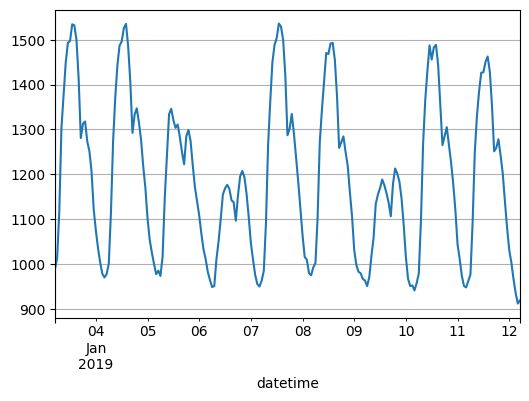

In [6]:
# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='datetime'>

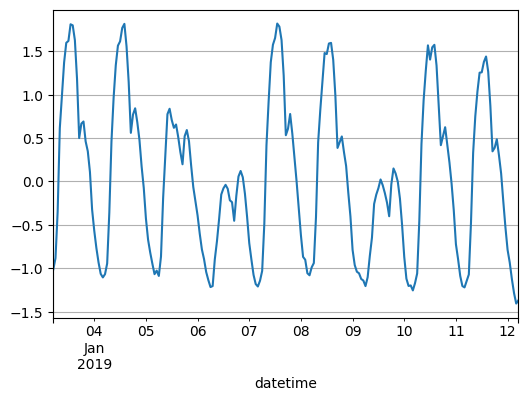

In [7]:
feature_scaler = StandardScaler()

# Airline Passgeners
#df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))

# Panama Electricity Load Forecasting
df_full[df_full.columns] = feature_scaler.fit_transform(df_full[df_full.columns])

# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

In [8]:
tstamp = df_full.index[-1]
tstamp

Timestamp('2019-12-31 23:00:00')

# Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [9]:
df_full.shape

(43775, 16)

# Model

In [10]:
from models.transformer import T5TimeSeries

## Transformer Model
### Initialized Model with Hyperparameters

In [11]:
model = T5TimeSeries(
    input_features_size=hyperparameters['input_features_size'],
    date_input_features_size=hyperparameters['date_input_features_size'],
    date_features_dim=hyperparameters['date_features_dim'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_encoder_layers=hyperparameters['num_encoder_layers'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
)

### Number of parameters

In [12]:
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters()):,}')

In [13]:
print('Number of parameters:')
print_model_parameters(model)

Number of parameters:
24,813,952


In [14]:
dummy_data_enc = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['input_features_size'])
dummy_date_enc = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['date_input_features_size'])

dummy_data_dec = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['input_features_size'])
dummy_date_dec = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['date_input_features_size'])

o = model(dummy_data_enc, dummy_data_dec, dummy_date_enc, dummy_date_dec)
o.shape

torch.Size([128, 216, 16])

# Dataset

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, lags, forecast):
        self.df = df
        self.lags = lags
        self.forecast = forecast
        self.window_size = lags + forecast
        
    def __len__(self):
        number_of_samples = self.df.shape[0]
        # make sure that last window fits
        return number_of_samples - self.window_size

    def __getitem__(self, start_idx):

        # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
        df_window = self.df.iloc[start_idx:start_idx+self.window_size]

        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp_lags = df_window[:self.lags].index
        # output (forecast) timestamps
        sample_timestamp_forecast = df_window[-self.forecast:].index
            
        # divide window into lags and forecast:
        # (hyperparameters['lags'], input_features_size)
        lags = sample_window[:self.lags, :]
        # (hyperparameters['forecast'], input_features_size)
        forecast = sample_window[-self.forecast:, :]
        #forecast_input  = forecast[:-1, :]
        #forecast_output = forecast[1:, :]
        
        # convert to tensor
        lags = torch.tensor(lags, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)
        
        # (lags, date_input_features_size)
        date_lags = torch.tensor([sample_timestamp_lags.month, sample_timestamp_lags.day, sample_timestamp_lags.hour], dtype=torch.float32).permute(1, 0)
        # (forecast, date_input_features_size)
        date_forecast = torch.tensor([sample_timestamp_forecast.month, sample_timestamp_forecast.day, sample_timestamp_forecast.hour], dtype=torch.float32).permute(1, 0)
        
        return lags, forecast, date_lags, date_forecast

In [16]:
dataset_full = TimeSeriesDataset(
    df_full,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

In [17]:
_lags, _forecast, _date_lags, _date_forecast = dataset_full[0]
_lags.shape, _forecast.shape, _date_lags.shape, _date_forecast.shape

(torch.Size([168, 16]),
 torch.Size([48, 16]),
 torch.Size([168, 3]),
 torch.Size([48, 3]))

### Train/Test Split

In [18]:
train_size = int(hyperparameters['split_ratio'] * len(dataset_full))
test_size = len(dataset_full) - train_size

train_size, test_size

(34847, 8712)

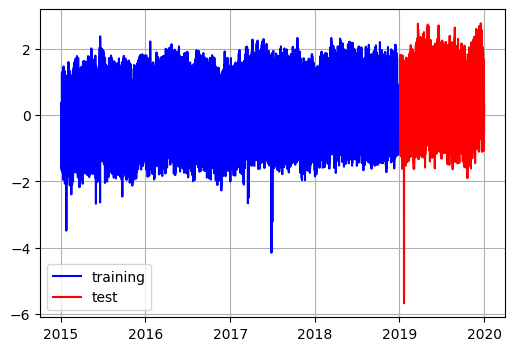

In [19]:
df_train = df_full.iloc[:train_size, :]
df_test = df_full.iloc[-test_size:, :]

# Airline Passgeners
#plt.plot(df_train.index, df_train['Passengers'], c='blue', label='training')
#plt.plot(df_test.index, df_test['Passengers'], c='red', label='test')

# Panama Electricity Load Forecasting
plt.plot(df_train.index, df_train['nat_demand'], c='blue', label='training')
plt.plot(df_test.index, df_test['nat_demand'], c='red', label='test')

plt.legend()

In [20]:
dataset_train = TimeSeriesDataset(
    df_train,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

dataset_test = TimeSeriesDataset(
    df_test,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

# Dataloader

In [21]:
dataloader_full = DataLoader(
    dataset_full,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

print(f'Number of batches (total): {len(dataloader_full)}')
print(f'Number of batches (train): {len(dataloader_train)}')
print(f'Number of batches (test): {len(dataloader_test)}')

Number of batches (total): 341
Number of batches (train): 271
Number of batches (test): 67


In [22]:
_lags_batch, _forecast_batch, _date_lags_batch, _date_forecast_batch = next(iter(dataloader_full))
# (hyperparameters['batch_size'], hyperparameters['lags'], NUM_FEATURES), # (hyperparameters['batch_size'], hyperparameters['forecast'], NUM_FEATURES)
_lags_batch.shape, _forecast_batch.shape, _date_lags_batch.shape, _date_forecast_batch.shape

(torch.Size([128, 168, 16]),
 torch.Size([128, 48, 16]),
 torch.Size([128, 168, 3]),
 torch.Size([128, 48, 3]))

In [23]:
len(dataloader_full)

341

# Training

### Training Functions

In [24]:
def train_iter(model, dataloader, optimizer, criterion, device):
    model.train()

    avg_loss = []
    
    for (lags, forecast, date_lags, date_forecast) in dataloader:

        lags = lags.to(device)
        forecast = forecast.to(device)
        date_lags = date_lags.to(device)
        date_forecast = date_forecast.to(device)

        forecast_input = forecast[:, :-1, :]
        forecast_output = forecast[:, 1:, :]

        date_forecast_input = date_forecast[:, :-1, :]
        # no need for date_forecast_output
        
        optimizer.zero_grad()
    
        forecast_pred = model(lags, forecast_input, date_lags, date_forecast_input)
        
        loss = criterion(forecast_pred, forecast_output)
        
        loss.backward()
        optimizer.step()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def eval_iter(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    for (lags, forecast, date_lags, date_forecast) in dataloader:
        
        lags = lags.to(device)
        forecast = forecast.to(device)
        date_lags = date_lags.to(device)
        date_forecast = date_forecast.to(device)

        forecast_input = forecast[:, :-1, :]
        forecast_output = forecast[:, 1:, :]

        date_forecast_input = date_forecast[:, :-1, :]
        # no need for date_forecast_output
        
        forecast_pred = model(lags, forecast_input, date_lags, date_forecast_input)

        loss = criterion(forecast_pred, forecast_output)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Start Training

In [25]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparameters['learning_rate']
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.1, 
    patience=3,
    min_lr=1e-6,
)

mse_loss = nn.MSELoss()

In [26]:
model.to(device)

for epoch in range(1, hyperparameters['num_epochs']+1):
        
    avg_train_loss = train_iter(
        model=model, 
        dataloader=dataloader_train, 
        optimizer=optimizer, 
        criterion=mse_loss, 
        device=device
    )
    
    avg_test_loss, _ = eval_iter(
        model=model, 
        dataloader=dataloader_test, 
        criterion=mse_loss, 
        device=device
    )

    # auto decrease LR when not improving
    scheduler.step(avg_test_loss)
    
    """
    # MANUAL LR SCHEDULING
    if epoch == 30:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1

    if epoch == 60:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1
    """
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:<3}, Training loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}, LR: {scheduler.get_last_lr()}')

Epoch: 5  , Training loss: 7.0726, Testing Loss: 7.3978, LR: [0.0001]
Epoch: 10 , Training loss: 6.1754, Testing Loss: 6.5309, LR: [0.0001]
Epoch: 15 , Training loss: 5.1285, Testing Loss: 5.1717, LR: [0.0001]
Epoch: 20 , Training loss: 1.6673, Testing Loss: 1.5858, LR: [0.0001]
Epoch: 25 , Training loss: 1.0932, Testing Loss: 1.0534, LR: [0.0001]
Epoch: 30 , Training loss: 0.8328, Testing Loss: 0.7862, LR: [0.0001]
Epoch: 35 , Training loss: 0.6556, Testing Loss: 0.6440, LR: [0.0001]
Epoch: 40 , Training loss: 0.5718, Testing Loss: 0.5871, LR: [0.0001]
Epoch: 45 , Training loss: 0.4819, Testing Loss: 0.5214, LR: [0.0001]
Epoch: 50 , Training loss: 0.4169, Testing Loss: 0.4574, LR: [0.0001]


# Testing
* NOTE: we prefer to use single windows step during prediction

In [27]:
@torch.no_grad()
def eval_iter_single_step(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    # single step
    for start_idx in range(0, len(df_test)):

        # single step window sliding
        df_window = df_test.iloc[start_idx:start_idx+hyperparameters['window_size'], :]
        
        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp_lags = df_window[:hyperparameters['lags']].index
        # output (forecast) timestamps
        sample_timestamp_forecast = df_window[-hyperparameters['forecast']:].index
        
        # covnert to tensor
        lags = torch.tensor(sample_window[:hyperparameters['lags']], dtype=torch.float32, device=device)
        forecast = torch.tensor(sample_window[-hyperparameters['forecast']:], dtype=torch.float32, device=device)
        
        # (lags, date_input_features_size)
        date_lags = torch.tensor([sample_timestamp_lags.month, sample_timestamp_lags.day, sample_timestamp_lags.hour], dtype=torch.float32, device=device).permute(1, 0)
        # (forecast, date_input_features_size)
        date_forecast = torch.tensor([sample_timestamp_forecast.month, sample_timestamp_forecast.day, sample_timestamp_forecast.hour], dtype=torch.float32, device=device).permute(1, 0)
        
        # artificially add batch dimension
        # (we are not using the dataloader here!)
        lags = lags.unsqueeze(0)
        forecast = forecast.unsqueeze(0)
        date_lags = date_lags.unsqueeze(0)
        date_forecast = date_forecast.unsqueeze(0)

        forecast_pred = model(lags, forecast, date_lags, date_forecast)

        loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        predictions.append(forecast_pred[0][0].cpu().numpy())

    return sum(avg_loss) / len(avg_loss), predictions

In [28]:
_, pred_sliding= eval_iter_single_step(
    model=model, 
    dataloader=dataloader_test, 
    criterion=mse_loss, 
    device=device
)

len(pred_sliding)

8712

In [29]:
df_full.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [30]:
sliding_results_dict = {}

pred_sliding_array = np.array(pred_sliding)

for feature_id, feature_key in enumerate(df_full.columns):
    sliding_results_dict[feature_key] = pred_sliding_array[:, feature_id]
        
df_sliding = pd.DataFrame(data=sliding_results_dict, index=df_test.index)

df_sliding.head(10)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-01-03 00:00:00,-1.330897,24.875402,0.013709,0.048807,13.237625,22.773354,0.015303,0.079422,6.326868,21.593912,0.012742,0.153805,4.353138,-0.030751,-0.006304,0.747516
2019-01-03 01:00:00,-1.402954,24.785547,0.013898,0.046983,13.611894,22.551483,0.015218,0.077210,6.385417,21.429394,0.013024,0.153105,4.508686,-0.022168,-0.007954,0.715648
2019-01-03 02:00:00,-1.379191,24.818386,0.014157,0.044807,14.289472,22.518322,0.015237,0.074514,6.566378,21.422562,0.013316,0.151611,4.609760,-0.024639,-0.009734,0.686044
2019-01-03 03:00:00,-1.318893,24.923847,0.014292,0.043581,14.741022,22.619116,0.015292,0.072189,6.725510,21.506035,0.013469,0.150606,4.640031,-0.034918,-0.010419,0.672405
2019-01-03 04:00:00,-1.292522,25.048458,0.014067,0.044317,14.264035,22.780659,0.015316,0.071196,6.652721,21.604975,0.013292,0.150973,4.565444,-0.044544,-0.007303,0.691166
2019-01-03 05:00:00,-1.200072,25.271597,0.013783,0.045398,13.701624,23.098839,0.015417,0.070302,6.607088,21.819731,0.013038,0.151453,4.435112,-0.052554,-0.002612,0.721415
2019-01-03 06:00:00,-1.073890,25.535898,0.013594,0.047582,13.257462,23.479563,0.015581,0.070743,6.748093,22.089497,0.012857,0.153434,4.389195,-0.049005,0.002605,0.750246
2019-01-03 07:00:00,-0.198136,26.753836,0.015258,0.066217,16.669554,25.468153,0.016743,0.086035,9.923748,23.716213,0.013770,0.172322,5.049547,-0.101513,-0.007133,0.763186
2019-01-03 08:00:00,0.620699,27.963924,0.016178,0.073350,19.702122,27.583059,0.017533,0.095724,12.023203,25.413774,0.014021,0.175971,4.971492,-0.055217,-0.026837,0.776136


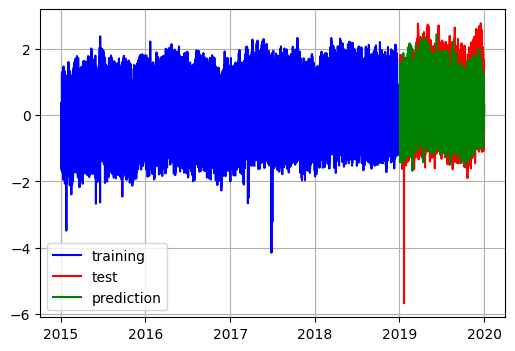

In [31]:
selected_feature = 'nat_demand'
plt.plot(df_train.index, df_train[selected_feature], c='blue', label='training')
plt.plot(df_sliding.index, df_test[selected_feature], c='red', label='test')
plt.plot(df_sliding.index, df_sliding[selected_feature] , c='green', label='prediction')
plt.legend()

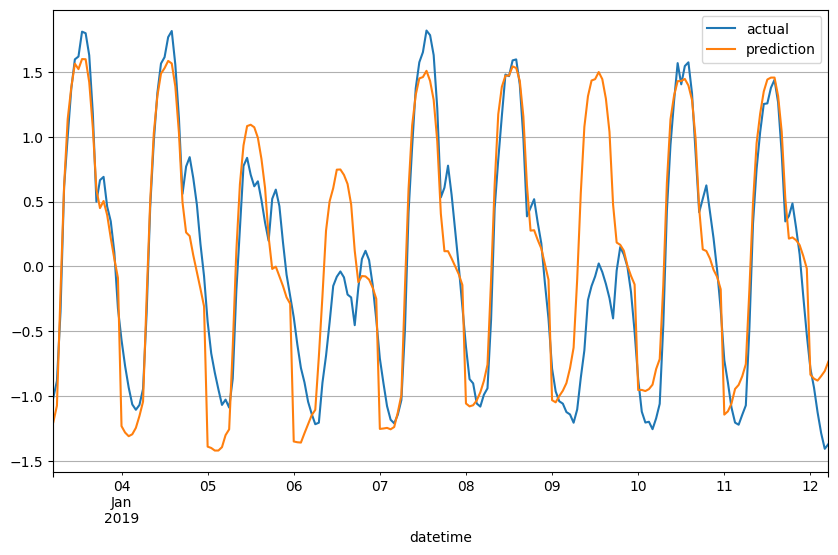

In [32]:
plt.figure(figsize=(10, 6))
df_test.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='actual')
df_sliding.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='prediction')
plt.legend()

# Save Model

In [33]:
os.makedirs('./saved_models', exist_ok=True)

torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': hyperparameters,
    },
    './saved_models/T5TimeSeries.pt'
)

# Generative Forecast

In [34]:
@torch.no_grad()
def generative_forecast(model, data, num_steps, lag_window_size):
    model.eval()
    
    predictions = []
    time_indexes = []

    _device = next(model.parameters()).device
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=_device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    timestamps = df_full.index
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]

    def generate_date_tensor(_timestamp, _lags, _device):
        _timestamp = _timestamp[-lag_window_size:]
        date_lags, date_forecast = _timestamp[-(lag_window_size+1):-1], _timestamp[-1:]
        
        date_lags_t = torch.tensor([date_lags.month, date_lags.day, date_lags.hour], dtype=torch.float32, device=_device).permute(1, 0)
        date_forecast_t = torch.tensor([date_forecast.month, date_forecast.day, date_forecast.hour], dtype=torch.float32, device=_device).permute(1, 0)
        
        return date_lags_t, date_forecast_t

    # get the last lag steps
    # +1 is for a single forecast step to initiate generative forecast
    lags = lags[:, -(lag_window_size+1):, :]
    # use the last step of lags to initiate forecast
    forecast_init = lags[:, -1:, :]
    lags = lags[:, -(lag_window_size+1):-1, :]
    #print(lags)

    # date
    # (1 (dummy batch), lag_window_size+1, date_input_features_size)
    date_lags, date_forecast = generate_date_tensor(timestamps, lag_window_size+1, device)
    date_lags = date_lags.unsqueeze(0)
    date_forecast = date_forecast.unsqueeze(0)
    
    # single step
    for idx in range(num_steps):
                
        forecast_pred = model(lags, forecast_init, date_lags, date_forecast)
        
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        # TAKE THE LAST FORECAST
        predictions.append(forecast_pred[0][-1].cpu().numpy())

        #print(forecast_pred.shape, forecast_pred[0][-1])
        
        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)
        
        # append last forecast to the end
        forecast_init = torch.cat((forecast_init, forecast_pred[:, -1:, :].detach()), dim=1)
        
        # next timestamp
        timestamps = timestamps + delta_time

        # append last timestamp to the end
        _, date_forecast_next = generate_date_tensor(timestamps, lag_window_size+1, device)
        date_forecast_next = date_forecast_next.unsqueeze(0)
        date_forecast = torch.cat((date_forecast, date_forecast_next), dim=1)

    return predictions, time_indexes

In [35]:
pred_generative, time_indexes_generative = generative_forecast(model, df_full.values, 48, hyperparameters['lags'])

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_full.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

# REVERSE THE PREPROCESSING FOR ORIGINAL RANGE
df_generative[df_generative.columns] = feature_scaler.inverse_transform(df_generative[df_generative.columns])    

In [36]:
df_generative.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
2020-01-01 00:00:00,-0.188105,26.471968,0.021998,0.021871,13.677945,24.320902,0.014705,0.063028,3.833786,22.936703,0.016726,0.132128,2.874953,18.847788,1.094893,0.569142
2020-01-01 01:00:00,-0.459206,27.087589,0.022528,0.045522,12.931838,25.829409,0.013384,0.058025,3.615412,24.068033,0.015814,0.124937,2.006367,20.591747,1.038018,0.597669
2020-01-01 02:00:00,-0.324975,27.533262,0.022574,0.055019,12.816737,26.813675,0.012836,0.065031,3.700307,24.844196,0.015671,0.123207,1.922399,21.026134,0.997022,0.584623
2020-01-01 03:00:00,-0.175104,27.931364,0.022448,0.060908,12.931892,27.563229,0.012783,0.071212,4.001012,25.471741,0.015499,0.123682,1.940193,21.017385,0.978780,0.592151
2020-01-01 04:00:00,-0.035788,28.293911,0.022243,0.065832,13.049545,28.218628,0.012861,0.077094,4.337420,26.030659,0.015304,0.125389,1.966895,20.910194,0.969687,0.607026


<Axes: >

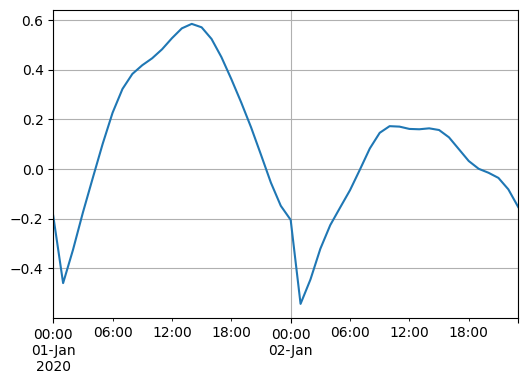

In [37]:
df_generative[selected_feature].plot()